### Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.metrics import f1_score, classification_report, confusion_matrix

### Data Overview

In [10]:
data_path = os.path.join(os.getcwd(), "..", "DataSets\Churn_Modelling.csv")
df = pd.read_csv(data_path)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
# adjast data columns
df.columns = df.columns.str.strip().str.replace(" ", "_")

In [12]:
# Drop Un nessaccery columns
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [13]:
# Some data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [14]:
# Some data description
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### EDA

In [15]:
# Show the categories in the Geography feature and there counts
df["Geography"].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

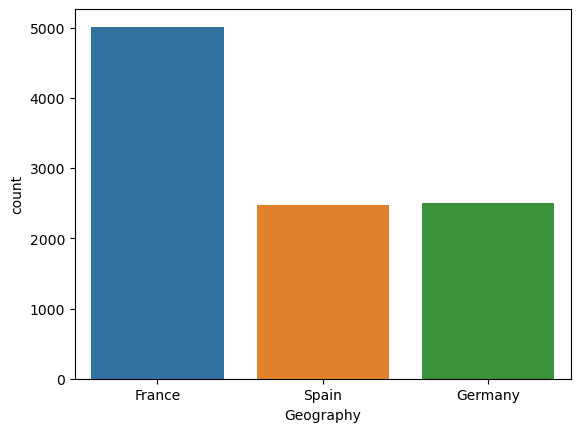

In [16]:
# Countplot for the categories in the Geography feature
sns.countplot(data=df, x="Geography")
plt.show()

In [17]:
# Show the class freq
df["Exited"].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

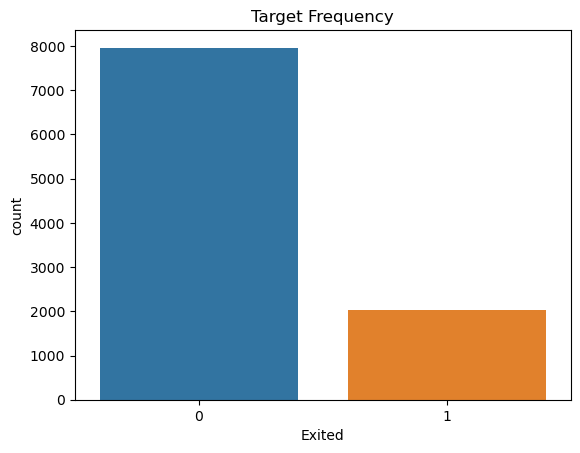

In [18]:
# Show the frequency of the target classes
sns.countplot(data=df, x="Exited")
plt.title("Target Frequency")
plt.show()

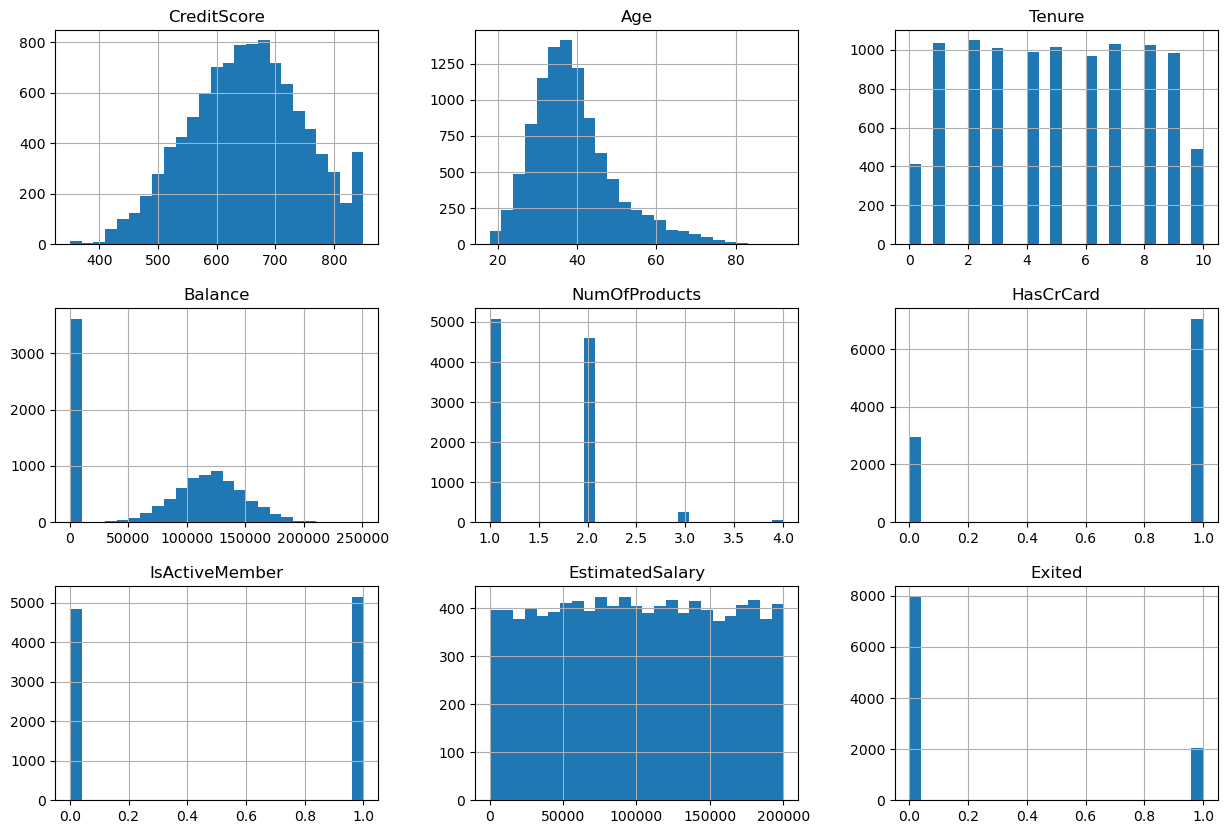

In [19]:
# Shoe Histogram distrebution for the numerical features
df.hist(bins=25, figsize=(15, 10))
plt.show()

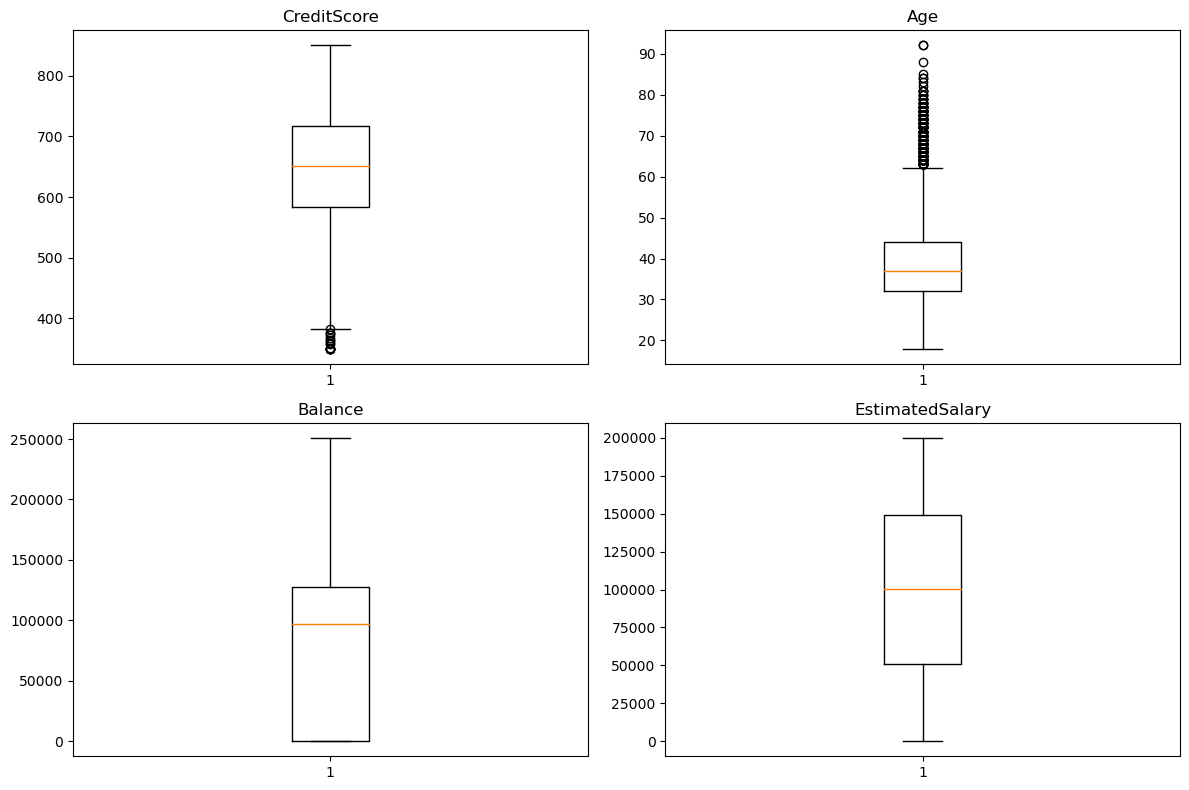

In [20]:
# Boxplot for the continuous features
continues_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, feature in enumerate(continues_features):
     row, col = divmod(i, 2)
     axes[row, col].boxplot(df[feature])
     axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

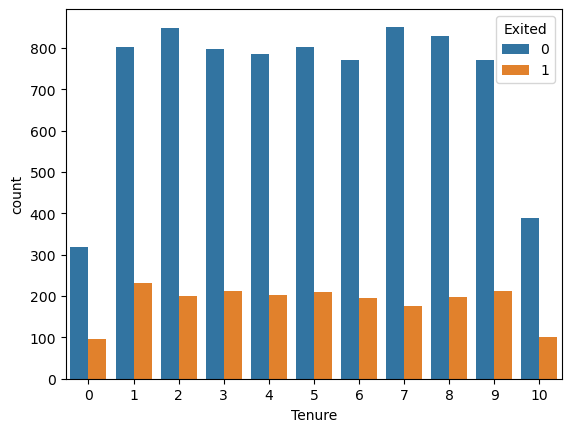

In [21]:
# Relation between Tenure and Exited
sns.countplot(data=df, x="Tenure", hue="Exited")
plt.show()

In [22]:
df["Geography"].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [23]:
Geo_with_exi = df.groupby("Geography")["Exited"].value_counts()
Geo_with_exi

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: count, dtype: int64

In [ ]:
# Show the number of Exited and Not Exited based on the Geography feature
Geo_with_exi = Geo_with_exi.unstack().reset_index()
Geo_with_exi.columns = ["Geography", "Not Exited", "Exited"]
Geo_with_exi

,Geography,Not Exited,Exited
0,France,4204,810
1,Germany,1695,814
2,Spain,2064,413


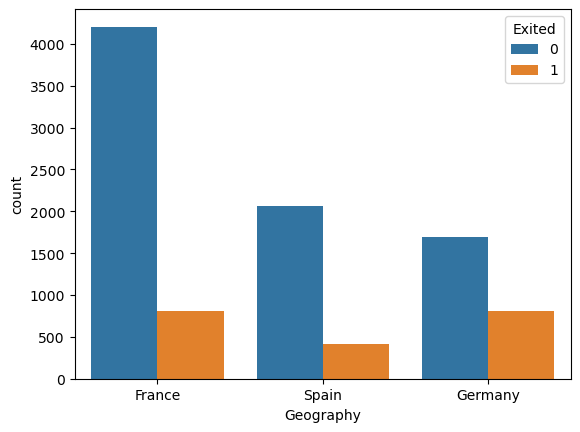

In [25]:
# Relation between Exited and Geography
sns.countplot(data=df, x="Geography", hue="Exited")
plt.show()

### Split the data

In [26]:
# split to features and target
X = df.drop(columns=["Exited"], axis=1)
y = df["Exited"]

# Split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y, shuffle=True)

# Show the shapes
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (8000, 10)
y_train shape (8000,)
X_test shape (2000, 10)
y_test shape (2000,)


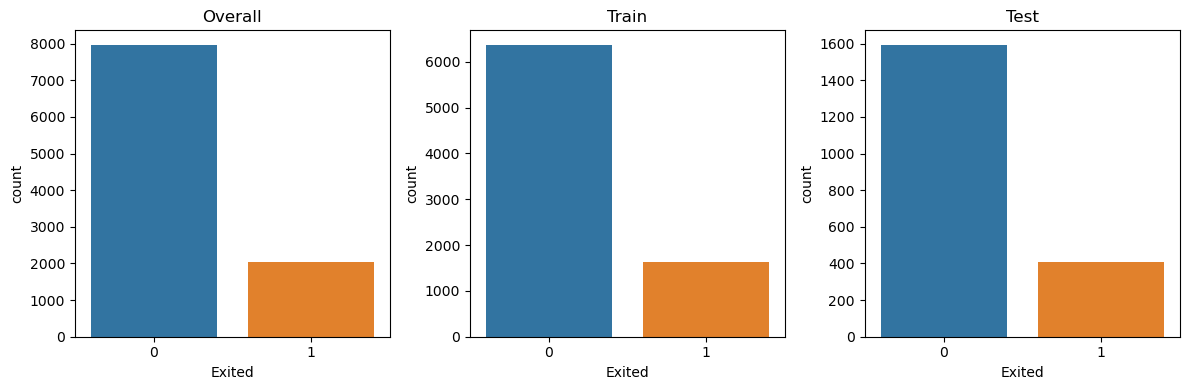

In [27]:
# Boxplot for the Targets
Targets = [y, y_train, y_test]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Overall", "Train", "Test"]
for i, (target, title) in enumerate(zip(Targets, titles)):
     sns.countplot(x=target, ax=axes[i])
     axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [28]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2151,753,France,Male,57,7,0.00,1,1,0,159475.08
8392,739,Germany,Male,32,3,102128.27,1,1,0,63981.37
5006,755,Germany,Female,37,0,113865.23,2,1,1,117396.25
4117,561,France,Male,37,5,0.00,2,1,0,83093.25
7182,692,Germany,Male,49,6,110540.43,2,0,1,107472.99


In [29]:
# Features Slicing 
continues_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
categorical_features = [feature for feature in X_train.columns if X_train[feature].dtype not in ["float32", "float64", "int32", "int64"]]
descrite_features = list(set(X_train.columns) - set(categorical_features).union(set(continues_features)))

In [30]:
categorical_features

['Geography', 'Gender']

In [31]:
descrite_features

['HasCrCard', 'NumOfProducts', 'IsActiveMember', 'Tenure']

In [ ]:
# Show the features association for the contenous features with the target using (ANOVA)
_, p_value = f_classif(X_train[continues_features], y_train)
for p_val, feature in zip(list(p_value), continues_features):
     if p_val < 0.5:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value reject H0 and there are association " )
     else:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value accept H0 and there are association " )

Feature: [CreditScore] Has P_value: [0.002355793914312166], So this p_value reject H0 and there are association 
Feature: [Age] Has P_value: [2.0307192202489025e-144], So this p_value reject H0 and there are association 
Feature: [Balance] Has P_value: [1.14364218149467e-27], So this p_value reject H0 and there are association 
Feature: [EstimatedSalary] Has P_value: [0.06998810504912935], So this p_value reject H0 and there are association 


In [ ]:
# Show the features association for the categorical features with the target using (chi2)
_, p_value = chi2(OrdinalEncoder().fit_transform(X_train[categorical_features]), y_train)
for p_val, feature in zip(list(p_value), categorical_features):
     if p_val < 0.5:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value reject H0 and there are association " )
     else:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value accept H0 and there are association " )

Feature: [Geography] Has P_value: [0.0010084417373813336], So this p_value reject H0 and there are association 
Feature: [Gender] Has P_value: [1.9319354245456756e-10], So this p_value reject H0 and there are association 


In [ ]:
# Show the features association for the descrite features with the target using (chi2)
_, p_value = chi2(X_train[descrite_features], y_train)
for p_val, feature in zip(list(p_value), descrite_features):
     if p_val < 0.5:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value reject H0 and there are association " )
     else:
          print(f"Feature: [{feature}] Has P_value: [{p_val}], So this p_value accept H0 and there are association " )

Feature: [HasCrCard] Has P_value: [0.48327153807473056], So this p_value reject H0 and there are association 
Feature: [NumOfProducts] Has P_value: [0.021950120665268594], So this p_value reject H0 and there are association 
Feature: [IsActiveMember] Has P_value: [2.375773184297949e-21], So this p_value reject H0 and there are association 
Feature: [Tenure] Has P_value: [0.7841850585666378], So this p_value accept H0 and there are association 


### Data preprocessing

In [47]:
# pipeline for numerical features
num_pipeline = Pipeline(steps=[
     ("Imputer", SimpleImputer(strategy="median")),
     ("Scaler", StandardScaler())
])

# for categorical features
cate_pipeline = Pipeline(steps=[
     ("Imputer", SimpleImputer(strategy="most_frequent")),
     ("Encoder", OneHotEncoder(sparse_output=False, drop="first"))
])

# for descrite features
desc_pipeline = Pipeline(steps=[
     ("Imputer", SimpleImputer(strategy="most_frequent"))
])

# combine all
preprocessor = ColumnTransformer(transformers=[
     ("numarical", num_pipeline, continues_features),
     ("categorical", cate_pipeline, categorical_features),
     ("descrite", desc_pipeline, descrite_features)
])

# apply on the train data
processed_train_data = preprocessor.fit_transform(X_train)
processed_test_data = preprocessor.transform(X_test)

In [50]:
processed_train_data.shape

(8000, 11)

In [49]:
processed_test_data.shape

(2000, 11)

#### Dealing with unbalanced data

In [57]:
classes_normalized = 1 - (np.bincount(y_train) / len(y_train))
classes_normalized

array([0.20375, 0.79625])

In [58]:
class_weights = {}
for i in range(2):
     class_weights[i] = classes_normalized[i]
     
class_weights

{0: 0.20375, 1: 0.79625}

In [ ]:
# make a folder for the models
model_folder_path = os.path.join(os.getcwd(), "..", "models")
os.makedirs(model_folder_path, exist_ok=True)